# Pre-train SynthText

In [1]:
import sys
sys.path.append('../../')

%load_ext autoreload
%autoreload 2

from dl.data.text import augmentations, datasets, target_transforms, transforms
from dl.data.text.utils import batch_ind_fn_droptexts
from dl.models.ssd.textboxespp import TextBoxesPP

from dl.loss.textboxespp import TextBoxLoss, ConfidenceLoss
from dl.optim.scheduler import IterStepLR
from dl.log import *

#from torchvision import transforms > not import!!
from torch.utils.data import DataLoader
from torch.optim.adam import Adam
import torch

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
augmentation = augmentations.RandomSampled()
#augmentation = None

transform = transforms.Compose(
    [transforms.Resize((384, 384)),
     transforms.ToTensor(),
     transforms.Normalize(rgb_means=(0.485, 0.456, 0.406), rgb_stds=(0.229, 0.224, 0.225))]
)
target_transform = target_transforms.Compose(
    [target_transforms.Corners2Centroids(),
     #target_transforms.ToQuadrilateral(),
     target_transforms.OneHot(class_nums=datasets.SynthText_class_nums, add_background=True),
     target_transforms.ToTensor()]
)

#train_dataset = datasets.COCO2014Text_Dataset(ignore=target_transforms.TextDetectionIgnore(illegible=True), transform=transform, target_transform=target_transform, augmentation=None)
train_dataset = datasets.SynthTextDetectionDataset(ignore=None, transform=transform, target_transform=target_transform, augmentation=augmentation)

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          collate_fn=batch_ind_fn_droptexts,
                          num_workers=4,
                          pin_memory=True)

In [3]:
model = TextBoxesPP(input_shape=(384, 384, 3)).cuda()
model.load_vgg_weights()
print(model)

TextBoxesPP(
  (codec): TextBoxCodec(
    (encoder): TextBoxEncoder()
    (decoder): TextBoxDecoder()
  )
  (defaultBox): DBoxTextBoxOriginal()
  (predictor): TextBoxPredictor()
  (inferenceBox): InferenceBox()
  (feature_layers): ModuleDict(
    (convRL1_1): ConvRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL1_2): ConvRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (convRL2_1): ConvRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL2_2): ConvRelu(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dila

<IPython.core.display.Javascript object>


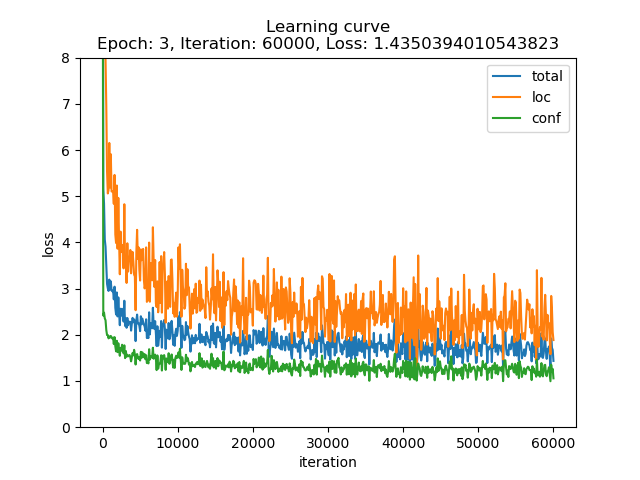

Training... Epoch: 1, Iter: 5000,	 [160000/858750	 (19%)]	Loss: 2.079097, Loc Loss: 3.174615, Conf Loss: 1.444174	Iter time: 0.3323
Saved model to ../weights/checkpoints/pretrained-synthtext_i-0005000_checkpoints20200615.pth

Training... Epoch: 1, Iter: 10000,	 [320000/858750	 (37%)]	Loss: 2.084016, Loc Loss: 2.833025, Conf Loss: 1.517411	Iter time: 0.3319
Saved model to ../weights/checkpoints/pretrained-synthtext_i-0010000_checkpoints20200615.pth

Training... Epoch: 1, Iter: 15000,	 [480000/858750	 (56%)]	Loss: 2.040695, Loc Loss: 3.035610, Conf Loss: 1.433573	Iter time: 0.3281
Saved model to ../weights/checkpoints/pretrained-synthtext_i-0015000_checkpoints20200615.pth

Training... Epoch: 1, Iter: 20000,	 [640000/858750	 (75%)]	Loss: 1.671736, Loc Loss: 2.197275, Conf Loss: 1.232281	Iter time: 0.3375
Saved model to ../weights/checkpoints/pretrained-synthtext_i-0020000_checkpoints20200615.pth

Training... Epoch: 1, Iter: 25000,	 [800000/858750	 (93%)]	Loss: 1.884486, Loc Loss: 2.916856

<IPython.core.display.Javascript object>


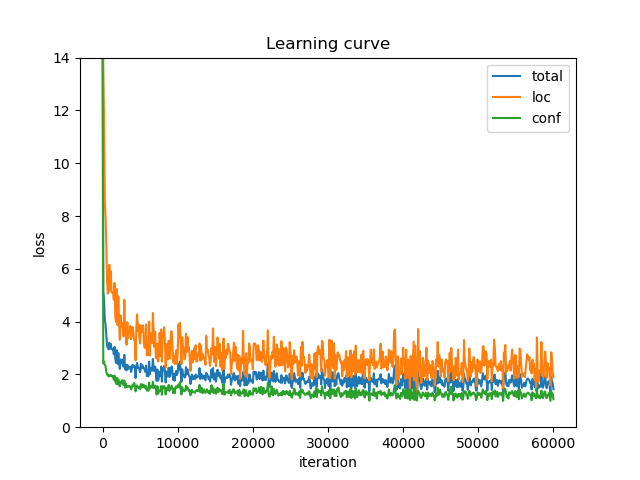

Saved graph to ../weights/results/pretrained-synthtext_learning-curve_i-60000.png


In [4]:
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

save_manager = SaveManager(modelname='pretrained-synthtext', interval=5000, max_checkpoints=15, plot_yrange=(0, 8), plot_interval=100)
trainer = TrainObjectDetectionJupyterLogger(LiveGraph(yrange=(0, 8)), TextBoxLoss(alpha=0.2, conf_loss=ConfidenceLoss(neg_factor=3)), model, optimizer)

trainer.train_iter(save_manager, 60000, train_loader)

Input any key. [n]/y


y


<IPython.core.display.Javascript object>


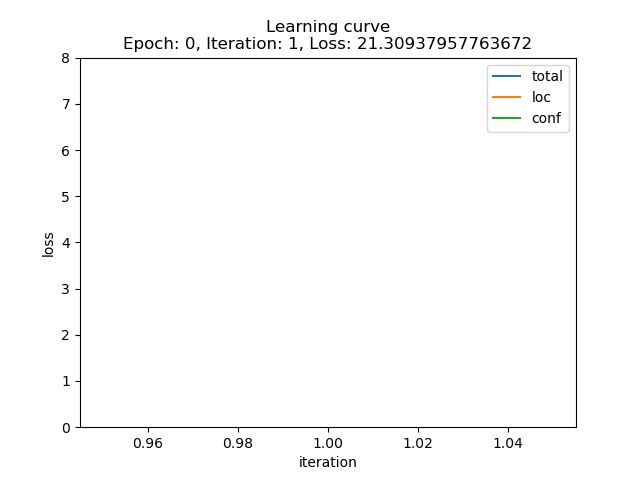

Training... Epoch: 0, Iter: 1,	 0%	total: 21.309380 loc: 36.489025 conf: 14.011574 	Iter time: 1.5859

RuntimeError: CUDA out of memory. Tried to allocate 1.12 GiB (GPU 0; 10.76 GiB total capacity; 4.16 GiB already allocated; 961.38 MiB free; 8.16 GiB reserved in total by PyTorch)

In [7]:
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

save_manager = SaveManager(modelname='pretrained-synthtext', interval=5000, max_checkpoints=15, plot_yrange=(0, 8), plot_interval=100)
trainer = TrainObjectDetectionJupyterLogger(LiveGraph(yrange=(0, 8)), TextBoxLoss(alpha=0.2, conf_loss=ConfidenceLoss(neg_factor=3)), model, optimizer)

trainer.train_iter(save_manager, 60000, train_loader)